# Environment Setting

In [89]:
using Pkg
Pkg.activate(joinpath(pwd(),".."))
using Random, Distributions, Plots, LaTeXStrings, PrettyTables
Random.seed!(123)

  Activating environment at `~/Desktop/ECON 627/Project.toml`


MersenneTwister(123)

# Question 1

## Part A

In [ ]:
function Π(λ,k; R = 10^5 )
    n_1 = length(λ)
    n_2 = length(k)
    Π = zeros(n_1, n_2)

    for i in 1:n_2
        ki = k[i]
        z = randn(ki,R)
        cv_vec = quantile.(Chisq.(ki),0.95) .* ones(R)
        nc = zeros(ki)
        for j in 1:n_1
            λj = λ[j]
            nc[1] = λj
            x_raw = (z .+ nc).^2
            x = sum(x_raw; dims = 1)
            t = x .> cv_vec'
            Π[j,i] = R^(-1) * sum(t)
        end
    end

    return Π

end

## Part B

In [27]:
k = [1,5,10]
λ = [0]
Π0 = Π(λ, k)

1×3 Matrix{Float64}:
 0.04974  0.04992  0.04972

When we set $\lambda = 0 $, we are actually making all the $X$'s to follow a central $\chi^2_k$ distribution. Therefore, given such a large repetition times, we expect the result to be close to $\alpha$, the type I error we set. As we can see, the results are pretty close to 0.05

## Part C

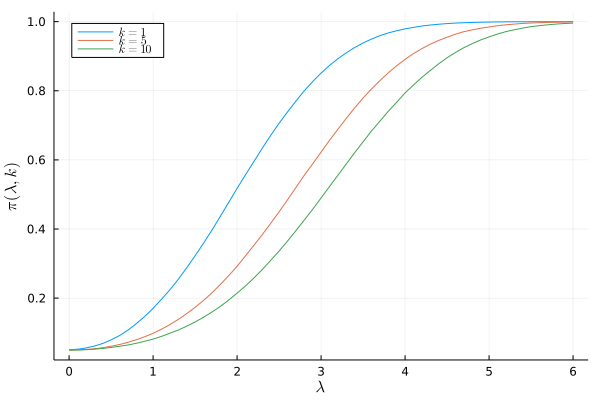

In [26]:
k = [1,5,10]
λ = 0:0.1:6
errors = Π(λ, k)

plot(λ,errors[:,1],label = L"k=1")
plot!(λ,errors[:,2],label=L"k=5")
plot!(λ,errors[:,3],label=L"k=10",legend=:topleft)
plot!(xlabel=L"\lambda",ylabel=L"\pi(\lambda,k)")

## Part D

We can see from the figure that when $k = 1 $, the power increases and converges to 1 the fastest, as $\lambda$ increases. As $k$ increases, the increase of power becomes slower at a decreasing rate. We can imagine that the line of $k = 100$ and $k = 200$ won't differ so much.

# Question 2
## Part A

In [ ]:
#Setting hyper-parameters
const δ = 0.5
const β1 = 1 
const π1 = 1
const k2 = 2
const β2 = ones(k2)
const π2 = ones(k2)

In [35]:
function data_generating(n)

    #Generate exogeneous variables
    mvnormal = MvNormal([0;0], [1 0 ; 0 1])
    V = randn(n,1)
    ϵ = randn(n,1)
    X2 = rand(mvnormal,n )'
    Z = randn(n,1)

    #Generate endogenous variables
    U = δ * V + ϵ
    X1 = π1 .* Z .+ X2 * π2 + V
    Y = β1 .* X1 + X2 * β2 + U

    return (Y = Y, X1 = X1, X2 = X2, Z = Z)
end

data_generating (generic function with 1 method)

## Part B

In [37]:
n = 30
(Y, X1, X2, Z) = data_generating(n)
X1,X2

([-1.4197846394020361; 1.2013764707993269; … ; 1.8277785835626168; 0.024788456060907127], [0.31715442464972143 -0.6792897308129671; 0.9000322986443142 -0.983479695295822; … ; 0.8791167989895962 1.1356836068159035; 1.099039024890866 -0.12639686507826275])

In [85]:
function SimulationBias1( n ; R = 10^5)
    errors = zeros(R)
    for i in 1:R
        (Y, X1, X2, Z) = data_generating(n)
        x = [X1 X2]
        z = [Z X2]

        n_1 = size(Y,1)
        Q = (z'* x)/n_1
        W = inv(z' * z/n_1)

        beta2SLS = (Q' * W * Q)^(-1) * Q' * W * (z' * Y)/n_1
        errors[i] = beta2SLS[1] - β1
    end

    bias = R^(-1) * sum(errors)
    return (bias = bias)
end


SimulationBias1 (generic function with 1 method)

## Part C

In [86]:
function SimulationBias2(n; R = 10^5)
    errors = zeros(R)
    for i in 1:R
        (Y, X1, X2, Z) = data_generating(n)
        x = [X1 X2]
        Z2 = Z.^2
        X22 = X2.^2
        Z3 = Z.^3
        X23 = X2.^3
        ZX = Z .* X2
        ZX2 = Z2 .* X22
        ZX3 = Z3 .* X23
        ZXX = Z .* X2[:,1] .* X2[:,2]

        z = [Z X2 Z2 X22 Z3 X23 ZX ZX2 ZX3 ZXX]
    

        n_1 = size(Y,1)
        Q = (z'* x)/n_1
        W = inv(z' * z/n_1)

        beta2SLS = (Q' * W * Q)^(-1) * Q' * W * (z' * Y)/n_1
        errors[i] = beta2SLS[1] - β1
    end

    bias = R^(-1) * sum(errors)
    return (bias = bias)
end


SimulationBias2 (generic function with 1 method)

## Part D

In [87]:
function Bias(ns::Array)
    n_length = size(ns,1)
    Bias = zeros(n_length,3)
    for i in 1:n_length
        ni = ns[i]
        Bias[i,1] = ni
        Bias[i,2] = SimulationBias1(ni)
        Bias[i,3] = SimulationBias2(ni)
    end
    return Bias
end       

Bias (generic function with 2 methods)

In [94]:
ns = [30, 100, 1000]
result = Bias(ns)
header = ["Sample Size(n)", "Bias", "Bias with Many IVs"]
pretty_table(result; header = header, alignment=:L)

┌────────────────┬──────────────┬────────────────────┐
│ Sample Size(n) │ Bias         │ Bias with Many IVs │
├────────────────┼──────────────┼────────────────────┤
│ 30.0           │ -0.0220582   │ 0.161328           │
│ 100.0          │ -0.00592224  │ 0.0562538          │
│ 1000.0         │ -0.000560141 │ 0.00601783         │
└────────────────┴──────────────┴────────────────────┘


From the table we can see that, with many IVs, the bias tends to be larger than that with 2 IVs.

## Part E

We can see that as n grows larger, both bias are smaller, but the relative relationships are not changed. Bias with many IVs would be approximately 10 times larger.